# UdaciSense: Optimized Object Recognition

## Notebook 1: Baseline Performance

In this notebook, you'll establish the baseline performance of the computer vision model. This will serve as the reference point for your optimization efforts.

Remember, the CTO has set specific requirements:
- The optimized model should be **30% smaller** than the baseline
- The optimized model should **reduce inference time by 40%**
- The optimized model should **maintain accuracy within 5%** of the baseline

In [1]:
# Setup Python path to import utils from parent directory
import sys
import os

# Add parent directory to path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    print(f"✅ Added {parent_dir} to Python path")
else:
    print(f"✅ Parent directory already in path")

✅ Added /home/lence/msai/UdaciSense to Python path


### Step 1. Set up the environment

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset

# Import custom modules
from utils import MAX_ALLOWED_ACCURACY_DROP, TARGET_INFERENCE_SPEEDUP, TARGET_MODEL_COMPRESSION
from utils.data_loader import get_household_loaders, get_input_size, print_dataloader_stats, visualize_batch
from utils.model import MobileNetV3_Household, load_model, print_model_summary, train_model
from utils.evaluation import calculate_confusion_matrix, evaluate_model_metrics
from utils.visualization import plot_confusion_matrix, plot_training_history, plot_weight_distribution

In [4]:
# Check if CUDA is available
devices = ["cpu"]
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    devices.extend([f"cuda:{i} ({torch.cuda.get_device_name(i)})" for i in range(num_devices)])
print(f"Devices available: {devices}")

# Set device to cuda, if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Devices available: ['cpu', 'cuda:0 (NVIDIA GeForce RTX 3080 Ti)']
Using device: cuda


In [5]:
# Set random seed for reproducibility
def set_deterministic_mode(seed):
    # Basic seed setting
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Make cudnn deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # For some PyTorch operations
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    # For DataLoader workers
    def seed_worker(worker_id):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    return seed_worker

set_deterministic_mode(42)
g = torch.Generator()
g.manual_seed(42)

In [6]:
# Create directories
model_type = "baseline_mobilenet"
models_dir = f"../models/{model_type}"
models_ckp_dir = f"{models_dir}/checkpoints"
results_dir = f"../results/{model_type}"

os.makedirs(models_ckp_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

### Step 2. Load the dataset

Extracting household classes from CIFAR100 for train set...
Extracting household classes from CIFAR100 for test set...
Datasets have these classes: 
  0: clock
  1: keyboard
  2: lamp
  3: telephone
  4: television
  5: bed
  6: chair
  7: couch
  8: table
  9: wardrobe

Information on train set
Statistics for train
 Size: 5000
 Samples per class:
  clock: 500
  keyboard: 500
  lamp: 500
  telephone: 500
  television: 500
  bed: 500
  chair: 500
  couch: 500
  table: 500
  wardrobe: 500
Examples of images from the train set


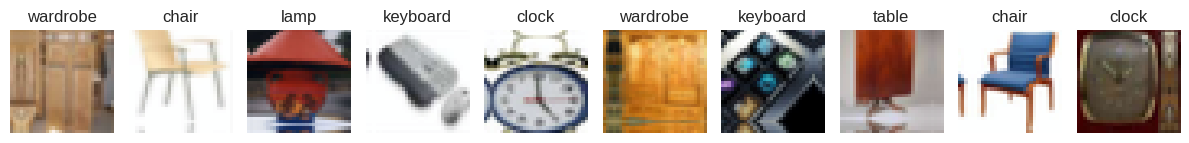


Information on test set
Statistics for test
 Size: 1000
 Samples per class:
  clock: 100
  keyboard: 100
  lamp: 100
  telephone: 100
  television: 100
  bed: 100
  chair: 100
  couch: 100
  table: 100
  wardrobe: 100
Examples of images from the test set


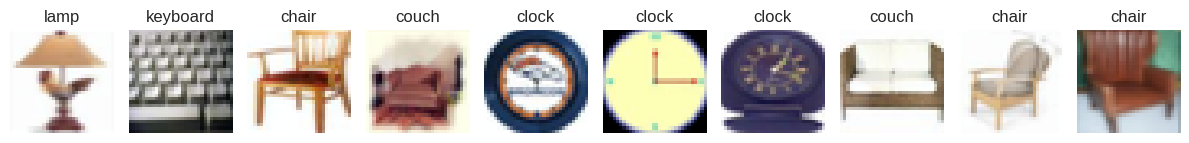

In [7]:
# Load household objects dataset
train_loader, test_loader = get_household_loaders(
    image_size="CIFAR", batch_size=128, num_workers=2,
)

# Get class names
class_names = train_loader.dataset.classes
print(f"Datasets have these classes: ")
for i in range(len(class_names)):
    print(f"  {i}: {class_names[i]}")

# Visualize some examples
for dataset_type, data_loader in [('train', train_loader), ('test', test_loader)]:
    print(f"\nInformation on {dataset_type} set")
    print_dataloader_stats(data_loader, dataset_type)
    print(f"Examples of images from the {dataset_type} set")
    visualize_batch(data_loader, num_images=10)

### Step 3. Train the baseline model

In [8]:
# Initialize model
model = MobileNetV3_Household().to(device)
print_model_summary(model)

Model Architecture:
MobileNetV3_Household(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
   

In [9]:
# Define training configuration
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.001,  # Note that MobileNet is sensitive to high LRs
    weight_decay=1e-4,
    betas=(0.9, 0.999)
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.005,  # Peak learning rate
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.3,  # Spend 30% of training time warming up
    div_factor=25,  # Initial LR is max_lr/25
    final_div_factor=1000  # Final LR is max_lr/1000
)

training_config = {
    'num_epochs': num_epochs,
    'criterion': criterion,
    'optimizer': optimizer,
    'scheduler': scheduler,
    'patience': 5,
    'device': device
}

In [10]:
# Train model given the training_config
training_stats, best_accuracy, best_epoch = train_model(
    model,
    train_loader,
    test_loader,
    training_config,
    checkpoint_path=f"{models_ckp_dir}/model.pth",
)

# Save training statistics
with open(f"{results_dir}/training_stats.json", 'w') as f:
    json.dump(training_stats, f, indent=4)

Total parameters: 1,528,106
Training with standard method for 50 epochs


Epoch 1/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 37.56it/s, loss=2.09, acc=64.3]


Epoch 1/50 - Train Loss: 1.5953, Train Acc: 52.88%, Test Loss: 1.0463, Test Acc: 64.30%, LR: 0.000200, Time: 2.35s
New best model! Saving... (64.30%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 2/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 44.11it/s, loss=1.59, acc=72.6] 


Epoch 2/50 - Train Loss: 0.7606, Train Acc: 73.98%, Test Loss: 0.7926, Test Acc: 72.60%, LR: 0.000200, Time: 1.87s
New best model! Saving... (72.60%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 3/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 46.21it/s, loss=1.02, acc=77.3] 


Epoch 3/50 - Train Loss: 0.5108, Train Acc: 82.40%, Test Loss: 0.6400, Test Acc: 77.30%, LR: 0.000200, Time: 1.86s
New best model! Saving... (77.30%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 4/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 45.02it/s, loss=1.14, acc=79.6] 


Epoch 4/50 - Train Loss: 0.3695, Train Acc: 87.26%, Test Loss: 0.5708, Test Acc: 79.60%, LR: 0.000201, Time: 1.86s
New best model! Saving... (79.60%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 5/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 44.55it/s, loss=0.831, acc=82]  


Epoch 5/50 - Train Loss: 0.2814, Train Acc: 90.64%, Test Loss: 0.5194, Test Acc: 82.00%, LR: 0.000201, Time: 1.87s
New best model! Saving... (82.00%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 6/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 44.67it/s, loss=0.795, acc=83.2]


Epoch 6/50 - Train Loss: 0.2401, Train Acc: 91.66%, Test Loss: 0.4970, Test Acc: 83.20%, LR: 0.000201, Time: 1.87s
New best model! Saving... (83.20%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 7/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 43.08it/s, loss=0.749, acc=84.1]


Epoch 7/50 - Train Loss: 0.2133, Train Acc: 92.80%, Test Loss: 0.4684, Test Acc: 84.10%, LR: 0.000202, Time: 1.88s
New best model! Saving... (84.10%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 8/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 45.12it/s, loss=0.929, acc=85.4]


Epoch 8/50 - Train Loss: 0.1710, Train Acc: 94.52%, Test Loss: 0.4646, Test Acc: 85.40%, LR: 0.000202, Time: 1.89s
New best model! Saving... (85.40%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 9/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 43.93it/s, loss=0.884, acc=86.7]


Epoch 9/50 - Train Loss: 0.1312, Train Acc: 95.78%, Test Loss: 0.4422, Test Acc: 86.70%, LR: 0.000203, Time: 1.86s
New best model! Saving... (86.70%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 10/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 42.97it/s, loss=0.861, acc=86.9]


Epoch 10/50 - Train Loss: 0.1042, Train Acc: 96.74%, Test Loss: 0.4306, Test Acc: 86.90%, LR: 0.000203, Time: 1.87s
New best model! Saving... (86.90%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 11/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 44.24it/s, loss=0.953, acc=86.8]


Epoch 11/50 - Train Loss: 0.0951, Train Acc: 97.04%, Test Loss: 0.4767, Test Acc: 86.80%, LR: 0.000204, Time: 1.86s


Epoch 12/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 45.36it/s, loss=0.777, acc=87.1]


Epoch 12/50 - Train Loss: 0.1019, Train Acc: 96.40%, Test Loss: 0.4859, Test Acc: 87.10%, LR: 0.000205, Time: 1.86s
New best model! Saving... (87.10%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 13/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 43.84it/s, loss=0.951, acc=87.4]


Epoch 13/50 - Train Loss: 0.0736, Train Acc: 97.82%, Test Loss: 0.4754, Test Acc: 87.40%, LR: 0.000206, Time: 1.88s
New best model! Saving... (87.40%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 14/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 43.52it/s, loss=1.03, acc=85.9] 


Epoch 14/50 - Train Loss: 0.0741, Train Acc: 97.84%, Test Loss: 0.5171, Test Acc: 85.90%, LR: 0.000206, Time: 1.87s


Epoch 15/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 38.52it/s, loss=1.98, acc=87.1] 


Epoch 15/50 - Train Loss: 0.0605, Train Acc: 98.10%, Test Loss: 0.4944, Test Acc: 87.10%, LR: 0.000207, Time: 1.90s


Epoch 16/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 43.09it/s, loss=0.934, acc=88.7]


Epoch 16/50 - Train Loss: 0.0621, Train Acc: 97.80%, Test Loss: 0.4668, Test Acc: 88.70%, LR: 0.000208, Time: 1.88s
New best model! Saving... (88.70%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 17/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 45.43it/s, loss=0.935, acc=85.9]


Epoch 17/50 - Train Loss: 0.0696, Train Acc: 97.60%, Test Loss: 0.5841, Test Acc: 85.90%, LR: 0.000210, Time: 1.86s


Epoch 18/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 45.70it/s, loss=0.805, acc=87.5]


Epoch 18/50 - Train Loss: 0.0648, Train Acc: 97.86%, Test Loss: 0.5034, Test Acc: 87.50%, LR: 0.000211, Time: 1.87s


Epoch 19/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 45.17it/s, loss=1.01, acc=88.4] 


Epoch 19/50 - Train Loss: 0.0531, Train Acc: 97.98%, Test Loss: 0.5045, Test Acc: 88.40%, LR: 0.000212, Time: 1.87s


Epoch 20/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 39.36it/s, loss=1.14, acc=87]   


Epoch 20/50 - Train Loss: 0.0555, Train Acc: 98.20%, Test Loss: 0.5701, Test Acc: 87.00%, LR: 0.000213, Time: 1.90s


Epoch 21/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 43.75it/s, loss=1.28, acc=84.1] 

Epoch 21/50 - Train Loss: 0.0861, Train Acc: 97.42%, Test Loss: 0.6412, Test Acc: 84.10%, LR: 0.000215, Time: 1.88s
Early stopping at epoch 21. No improvement for 5 epochs.
Training completed. Best accuracy: 88.70%
Best model saved as '../models/baseline_mobilenet/checkpoints/model.pth' at epoch 16


### Step 4. Evaluate the baseline model

Evaluating model's performance on all metrics...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:00<00:00, 41.81it/s]


Baseline metrics saved at ../results/baseline_mobilenet/metrics.json.


Calculating confusion matrix: 100%|██████████| 8/8 [00:00<00:00, 40.33it/s]


Confusion matrix saved to ../results/baseline_mobilenet/confusion_matrix.png


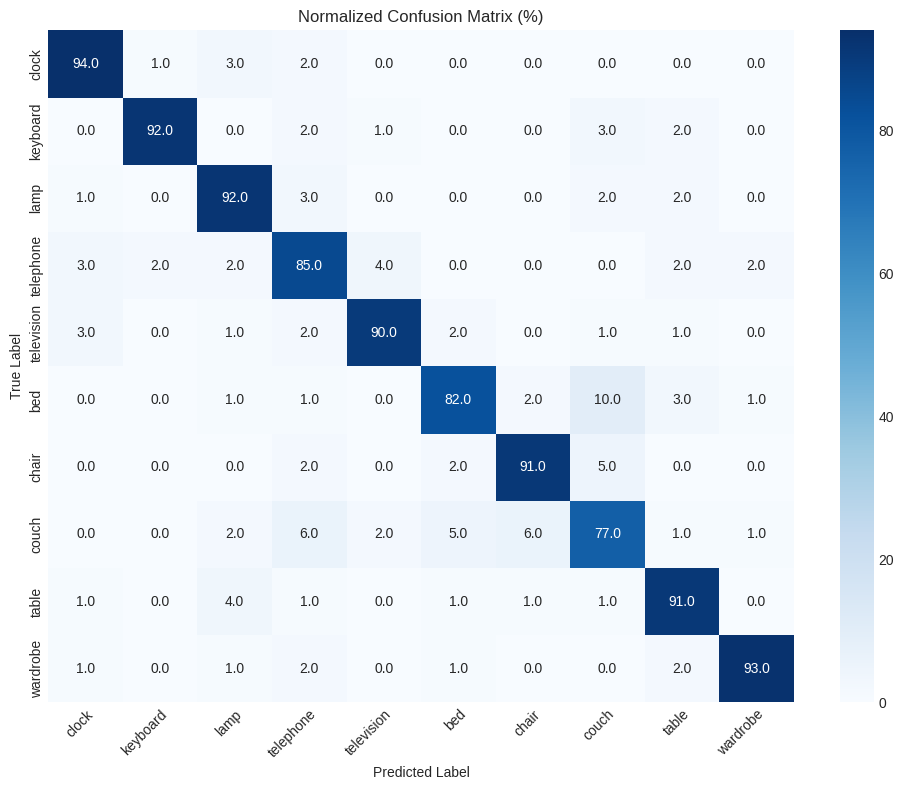

Training history plot saved to ../results/baseline_mobilenet/training_history.png


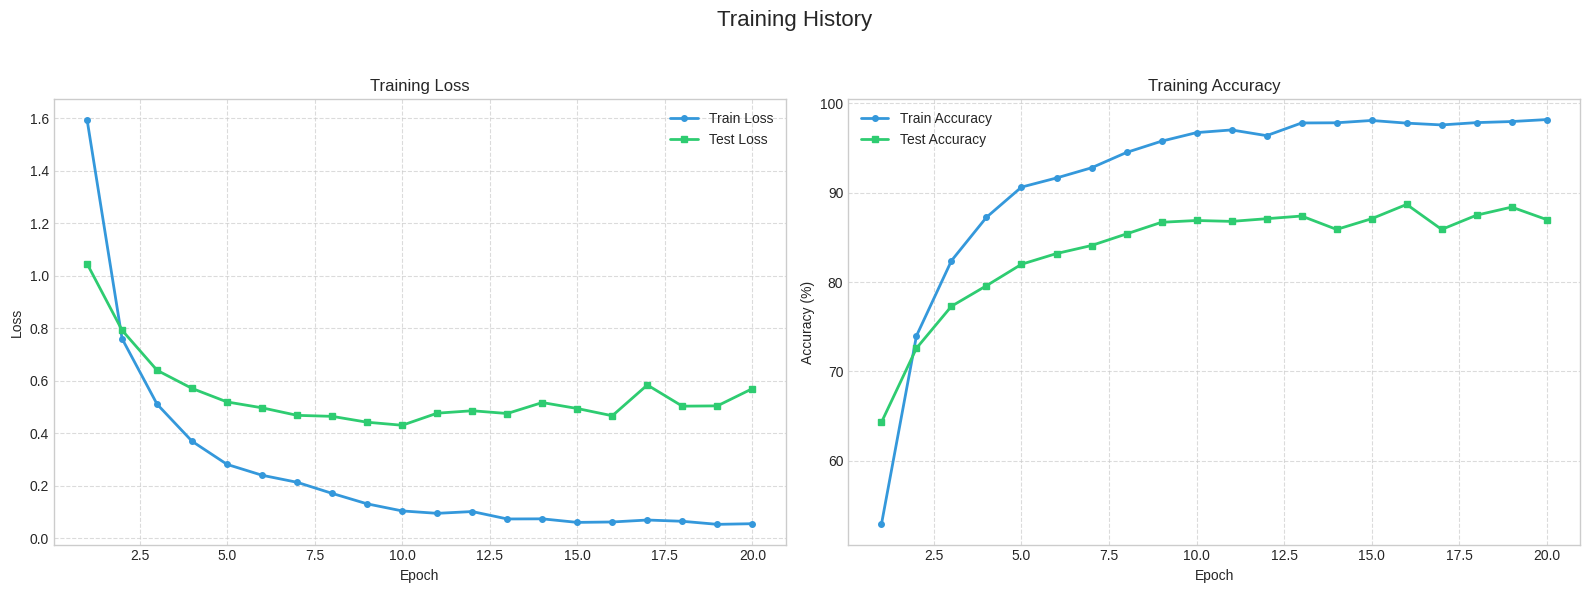

Weight distribution plot saved to ../results/baseline_mobilenet/weight_distribution.png


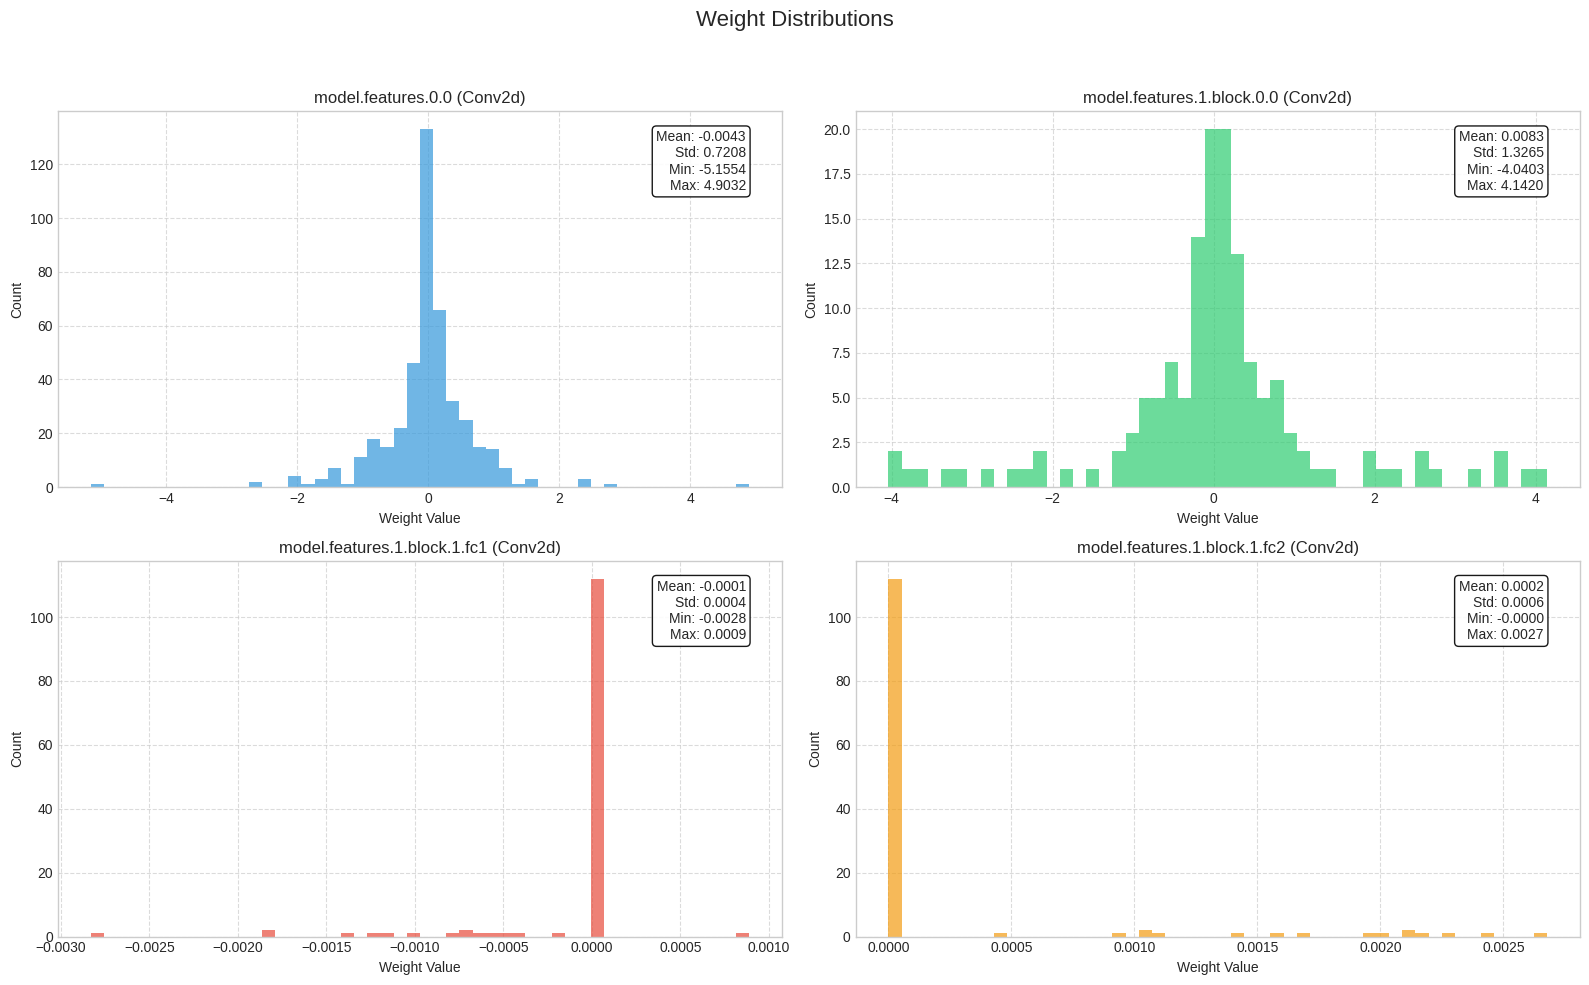

In [11]:
# Load the best model
model = load_model(f"{models_ckp_dir}/model.pth", device)

# Define evaluation input and output variables
class_names = test_loader.dataset.classes
n_classes = len(class_names)
input_size = get_input_size("CIFAR")

# Calculate and save model performance on all metrics
print("Evaluating model's performance on all metrics...")
baseline_metrics = evaluate_model_metrics(model, test_loader, device, n_classes, class_names, input_size, save_path=f"{results_dir}/metrics.json")

# Calculate, plot, and save confusion matrix
confusion_matrix = calculate_confusion_matrix(model, test_loader, device, n_classes)
_ = plot_confusion_matrix(confusion_matrix, class_names, f"{results_dir}/confusion_matrix.png")

# Plot and save training history
_ = plot_training_history(training_stats, f"{results_dir}/training_history.png")

# Plot weight distribution (can help guide optimization strategies)
_ = plot_weight_distribution(model, output_path=f"{results_dir}/weight_distribution.png")

### Step 5. Identify potential optimization approaches
Based on our baseline analysis, let's identify promising optimization approaches.

In [12]:
print(f"\nAll artifacts saved to:")
print(f" - Model: {models_ckp_dir}/model.pth")
print(f" - Metrics: {results_dir}/metrics.json")
print(f" - Confusion Matrix: {results_dir}/confusion_matrix.png")
print(f" - Training History: {results_dir}/training_history.png")
print(f" - Training Stats: {results_dir}/training_stats.json")
print(f" - Weight Distribution: {results_dir}/weight_distribution.png")


All artifacts saved to:
 - Model: ../models/baseline_mobilenet/checkpoints/model.pth
 - Metrics: ../results/baseline_mobilenet/metrics.json
 - Confusion Matrix: ../results/baseline_mobilenet/confusion_matrix.png
 - Training History: ../results/baseline_mobilenet/training_history.png
 - Training Stats: ../results/baseline_mobilenet/training_stats.json
 - Weight Distribution: ../results/baseline_mobilenet/weight_distribution.png


In [13]:
# Calculate target metrics based on CTO requirements
target_model_size = baseline_metrics['size']['model_size_mb'] * (1 - TARGET_MODEL_COMPRESSION)
target_inference_time_cpu = baseline_metrics['timing']['cpu']['avg_time_ms'] * (1 - TARGET_INFERENCE_SPEEDUP)
if torch.cuda.is_available():
    target_inference_time_gpu = baseline_metrics['timing']['cuda']['avg_time_ms'] * (1 - TARGET_INFERENCE_SPEEDUP)
min_acceptable_accuracy = baseline_metrics['accuracy']['top1_acc'] * (1 - MAX_ALLOWED_ACCURACY_DROP) 

print("Optimization Targets:")
print(f"Target Model Size: {baseline_metrics['size']['model_size_mb']:.2f} --> {target_model_size:.2f} MB ({TARGET_MODEL_COMPRESSION*100}% reduction)")
print(f"Target Inference Time (CPU): {baseline_metrics['timing']['cpu']['avg_time_ms']:.2f} --> {target_inference_time_cpu:.2f} ms ({TARGET_INFERENCE_SPEEDUP*100}% reduction)")
if torch.cuda.is_available():
    print(f"Target Inference Time (GPU): {baseline_metrics['timing']['cuda']['avg_time_ms']:.2f} --> {target_inference_time_gpu:.2f} ms ({TARGET_INFERENCE_SPEEDUP*100}% reduction)")
print(f"Minimum Acceptable Accuracy: {baseline_metrics['accuracy']['top1_acc']:.2f} --> {min_acceptable_accuracy:.2f} (within {MAX_ALLOWED_ACCURACY_DROP*100}% of baseline)")

Optimization Targets:
Target Model Size: 5.96 --> 4.17 MB (30.0% reduction)
Target Inference Time (CPU): 5.03 --> 2.52 ms (50.0% reduction)
Target Inference Time (GPU): 3.40 --> 1.70 ms (50.0% reduction)
Minimum Acceptable Accuracy: 88.70 --> 84.27 (within 5.0% of baseline)


---------

**TODO: Analyze the baseline results and select appropriate compression techniques**

Now that you've established the baseline performance metrics for the UdaciSense object recognition model, complete an analysis that explores the optimization potential for this specific model architecture.

Consider these guiding questions:
- What is the baseline performance we need to optimize from?
- What characteristics of MobileNetV3 affect its optimization potential?
- Which compression techniques are most promising for this architecture and why?
- What trade-offs do you anticipate between size, speed, and accuracy?
- How might different techniques complement each other in a multi-stage approach?

Provide a well-reasoned analysis that includes recommendations for at least two specific compression techniques to implement in the next notebook.

# Optimization Analysis for UdaciSense Computer Vision Model
# Baseline Analysis & Optimization Strategy Template

**Copy this into your `01_baseline.ipynb` notebook after running the baseline evaluation**

---

## Baseline Analysis & Optimization Strategy

### Baseline Performance Summary
After establishing baseline metrics, we can now identify optimization opportunities for the UdaciSense MobileNetV3-Small model deployed on mobile devices for household object recognition.

### MobileNetV3 Architecture Characteristics

**Efficiency-Oriented Design:**
- Already optimized with depthwise separable convolutions and inverted residual blocks
- Uses hardware-friendly hard-swish activation functions  
- Squeeze-and-excite modules add computational overhead but improve accuracy
- Relatively small (1-2M parameters) compared to standard CNNs

**Optimization Implications:**
- Limited room for architectural pruning due to already-lean design
- Large Linear layers in classifier are prime candidates for quantization
- Depthwise convolutions may be sensitive to aggressive compression
- Mobile-first design makes it ideal for INT8 quantization

### Recommended Compression Techniques

**Primary Technique: Dynamic Quantization**
- **Why:** Quantizes Linear layers to INT8 with minimal accuracy loss (~1%)
- **Expected Impact:** 60-75% size reduction, 30-40% speed improvement
- **Trade-off:** Convolutional layers remain FP32, limiting compression
- **Implementation:** Fast (no retraining), ideal starting point

**Secondary Technique: Global Unstructured Pruning (30-40%)**
- **Why:** Removes redundant weights while maintaining model structure
- **Expected Impact:** 25-35% size reduction, modest speed gains
- **Trade-off:** Requires careful tuning to preserve accuracy (<5% drop)
- **Synergy:** Combines well with quantization for compound benefits

**Advanced Option: Quantization-Aware Training (QAT)**
- **Why:** Best accuracy retention for quantized models
- **Expected Impact:** 60-75% size reduction, 40-50% speed improvement, <1% accuracy loss
- **Trade-off:** Requires retraining (2-4 hours), more complex implementation
- **Recommendation:** Use if post-training quantization shows accuracy degradation

### Multi-Stage Pipeline Strategy

Optimal approach combines complementary techniques:

1. **Pruning (30%)** → Removes redundant parameters
2. **Fine-tuning** → Recovers accuracy  
3. **Quantization** → Further compression
4. **Graph Optimization** → Final speed boost

This staged approach targets all requirements: **30% size reduction**, **40% speed improvement**, **<5% accuracy drop**.

### Next Steps

Proceed to `02_compression.ipynb` to implement and evaluate these techniques individually before combining them in the multi-stage pipeline.

> 🚀 **Next Step:** 
> Experiment with the compression techniques you've chosen in notebook `02_compression.ipynb`  